A lot of the code here will be hard to follow, but it serves just to illustrate the perfromance of the algorithm for the
research in the paper.

In [19]:
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random

Again lots of functions that will be explained later

In [20]:
def change_coord(data, init):

    rate_list_E = []
    rate_list_A1 = []
    rate_list_A2 = []
    rate_list_tE = []
    for i in range(len(data[0])-1):
        rate_list_E.append((data[0][i+1]-data[0][i])/(timespan[i+1]-timespan[i]))
        rate_list_A1.append((data[1][i+1]-data[1][i])/(timespan[i+1]-timespan[i]))
        rate_list_A2.append((data[2][i+1]-data[2][i])/(timespan[i+1]-timespan[i]))
        rate_list_tE.append((data[3][i+1]-data[3][i])/(timespan[i+1]-timespan[i]))
    rate_lists = [rate_list_E,rate_list_A1,rate_list_A2,rate_list_tE]

    return rate_lists

In [21]:
# Needed parameters
T = [323,363,393]
P = 50
KH= 1282
CH2 = P/KH
R= 8.314
timespan = [0, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 27, 31, 40, 50, 60, 90, 120, 150, 180, 240, 300, 360, 440, 530, 620, 810, 900, 955, 1246] #the time points measured at, can be extended or cut to see effects of data richness
time = timespan[-1]
init = [[1,0,0,0,1,0,0,0], [4,0,0,0,2,0,0,0], [8,0,0,0,1.5,0,0,0]] #initial conditions, you can add or remove one later and see how the data changes

In [22]:
def get_Eact(A, ktrue):
    T=363
    E = (np.log(ktrue/A))*R*T
    return E

In the cell below you can later change the noise values to maybe 0.1, and see how the data changes later on.

In [23]:
def get_noise():
    static_noise = np.random.normal(0,0.01,30)
    variable_noise = np.random.normal(0,0.05,30)
    return static_noise, variable_noise

In [24]:
def simulate_system(diff,pre_consts, E_acts,T):
    rate_consts = pre_consts*np.exp(E_acts/(R*T))
    print(rate_consts)
    sol_1 = integrate.solve_ivp(diff, [0,time], init[0], t_eval = timespan, args=[rate_consts])
    sol_2 = integrate.solve_ivp(diff, [0,time], init[1], t_eval = timespan, args=[rate_consts])
    sol_3 = integrate.solve_ivp(diff, [0,time], init[2], t_eval = timespan, args=[rate_consts]) 
    
    noisy_data_list_1 = []
    noisy_data_list_2 = []
    noisy_data_list_3 = []
    i = 0
    for res in range(len(sol_1.y)):
        static_noise,variable_noise = get_noise()
        noisy_data_1 = sol_1.y[i] + static_noise + np.multiply(sol_1.y[i],variable_noise)
        noisy_data_2 = sol_2.y[i] + static_noise + np.multiply(sol_2.y[i],variable_noise)
        noisy_data_3 = sol_3.y[i] + static_noise + np.multiply(sol_3.y[i],variable_noise)
        noisy_data_list_1.append(noisy_data_1)
        noisy_data_list_2.append(noisy_data_2)
        noisy_data_list_3.append(noisy_data_3)
        i += 1
    
    rate_lists_1  = change_coord(noisy_data_list_1,init[0])
    rate_lists_2  = change_coord(noisy_data_list_2,init[1])
    rate_lists_3  = change_coord(noisy_data_list_3,init[2])
    
    return [sol_1.y,sol_2.y,sol_3.y],[noisy_data_list_1,noisy_data_list_2,noisy_data_list_3],[rate_lists_1,rate_lists_2,rate_lists_3]

In [25]:
def get_r2(real,simul):
    return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2])) + (r2_score(real[3], simul[3]))

In [26]:
def true_r2(diff,pre_consts,E_acts,T, noisy_data, rate_data):
    #test R squared comparison for random values
    rate_consts = pre_consts*np.exp(E_acts/(R*T))
    k1,k2f,k2b,k3,k4,k5 = rate_consts
    ind = {'k1': k1, 'k2f': k2f, 'k2b': k2b, 'k3': k3, 'k4': k4, 'k5': k5}
    best_1 = integrate.solve_ivp(diff, [0,time], init[0], args = (ind,), t_eval = timespan)
    best_2 = integrate.solve_ivp(diff, [0,time], init[1], args = (ind,), t_eval = timespan)
    best_3 = integrate.solve_ivp(diff, [0,time], init[2], args = (ind,), t_eval = timespan)
    changed_rates_1 = change_coord(best_1.y,init[0])
    changed_rates_2 = change_coord(best_2.y,init[1])
    changed_rates_3 = change_coord(best_3.y,init[2])
    score = (get_r2(noisy_data[0], best_1.y)+(get_r2(noisy_data[1],best_2.y))+(get_r2(noisy_data[2],best_3.y)))
    score += (get_r2(rate_data[0],changed_rates_1)+get_r2(rate_data[1],changed_rates_2)+get_r2(rate_data[2],changed_rates_3))
    return score

In [27]:
def fit_sim(diff, noisy_data, rate_data, max_score):
    def residual(paras):

        """
        compute the residual between actual data and fitted data
        """
        subject = {'k1': paras['k1'].value, 'k2f': paras['k2f'].value, 'k2b': paras['k2b'].value, 'k3': paras['k3'].value, 'k4': paras['k4'].value, 'k5': paras['k5'].value}

        sol_1 = integrate.solve_ivp(diff, [0,time], init[0], args = (subject,), t_eval = timespan)
        sol_2 = integrate.solve_ivp(diff, [0,time], init[1], args = (subject,), t_eval = timespan)
        sol_3 = integrate.solve_ivp(diff, [0,time], init[2], args = (subject,), t_eval = timespan)

        changed_rates_1 = change_coord(sol_1.y,init[0])
        changed_rates_2 = change_coord(sol_2.y,init[1])
        changed_rates_3 = change_coord(sol_3.y,init[2])

        score = (get_r2(noisy_data[0], sol_1.y)+(get_r2(noisy_data[1],sol_2.y))+(get_r2(noisy_data[2],sol_3.y)))
        score += (get_r2(rate_data[0],changed_rates_1)+get_r2(rate_data[1],changed_rates_2)+get_r2(rate_data[2],changed_rates_3))
        print(score)
        return max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score



    # measured data (timespan, and noisy data list [0])
    plt.figure()
    

    # set parameters including bounds; you can also fix parameters (use vary=False)
    params = Parameters()
    params.add('k1', value=0.01, min=1e-10, max=1)
    params.add('k2f', value=0.01, min=1e-10, max=1)
    params.add('k2b', value=0.01, min=1e-10, max=1)
    params.add('k3', value=0.01, min=1e-10, max=1)
    params.add('k4', value=0.01, min=1e-10, max=1)
    params.add('k5', value=0.01, min=1e-10, max=1)


    # fit model
    results = minimize(residual, params, method='leastsq', max_nfev = 1000)  # leastsq nelder
    # check results of the fit
    fin_sub = {'k1': results.params['k1'].value, 'k2f': results.params['k2f'].value, 'k2b': results.params['k2b'].value, 'k3': results.params['k3'].value, 'k4': results.params['k4'].value, 'k5': results.params['k5'].value}
    data_fitted = integrate.solve_ivp(diff, [0,time], init[0], args = (fin_sub,), t_eval = timespan)
    print(residual(results.params)[0])

    # plot fitted data
    plt.figure()
    plt.scatter(timespan, noisy_data[0][0], marker='o', label='measured data CE')
    plt.scatter(timespan, noisy_data[0][1], marker='o', label='measured data CA1')
    plt.scatter(timespan, noisy_data[0][2], marker='o', label='measured data CA2')
    plt.scatter(timespan, noisy_data[0][3], marker='o', label='measured data CtE')
    plt.plot(timespan, data_fitted.y[0], '-', linewidth=2, label='fitted data CE')
    plt.plot(timespan, data_fitted.y[1], '-', linewidth=2, label='fitted data CA1')
    plt.plot(timespan, data_fitted.y[2], '-', linewidth=2, label='fitted data CA2')
    plt.plot(timespan, data_fitted.y[3], '-', linewidth=2, label='fitted data CtE')
    plt.legend()
    # display fitted statistics
    report_fit(results)
    
    return results.params

In [28]:
def get_lines(T,constants):
    A1, A2f, A2b, A3, A4, A5 = constants['A1'],constants['A2f'],constants['A2b'],constants['A3'],constants['A4'],constants['A5']
    E1, E2f, E2b, E3, E4, E5 = constants['E1'],constants['E2f'],constants['E2b'],constants['E3'],constants['E4'],constants['E5']
    tk1 = A1*np.exp(-E1/(R*T))
    tk2f = A2f*np.exp(-E2f/(R*T))
    tk2b = A2b*np.exp(-E2b/(R*T))
    tk3 = A3*np.exp(-E3/(R*T))
    tk4 = A4*np.exp(-E4/(R*T))
    tk5 = A5*np.exp(-E5/(R*T))
    ind_const= {'k1': tk1, 'k2f': tk2f,'k2b': tk2b, 'k3': tk3, 'k4': tk4, 'k5': tk5}
    lines_1 = integrate.solve_ivp(diff, [0,time], init[0], args = (ind_const,), t_eval = timespan)
    lines_2 = integrate.solve_ivp(diff, [0,time], init[1], args = (ind_const,), t_eval = timespan)
    lines_3 = integrate.solve_ivp(diff, [0,time], init[2], args = (ind_const,), t_eval = timespan)
    return lines_1.y, lines_2.y, lines_3.y

In [29]:
def fit_sim_full(diff, noisy_data, rate_data, max_score, temperatures,guesses):
    def residual(paras):

        """
        compute the residual between actual data and fitted data
        """
        subject = {'A1': paras['A1'].value, 'A2f': paras['A2f'].value, 'A2b': paras['A2b'].value, 'A3': paras['A3'].value, 'A4': paras['A4'].value, 'A5': paras['A5'].value, 'E1': paras['E1'].value, 'E2f': paras['E2f'].value, 'E2b': paras['E2b'].value,  'E3': paras['E3'].value, 'E4': paras['E4'].value, 'E5': paras['E5'].value}
        
        A1, A2f, A2b, A3, A4, A5 = subject['A1'],subject['A2f'],subject['A2b'],subject['A3'],subject['A4'],subject['A5']
        E1, E2f, E2b, E3, E4, E5 = subject['E1'],subject['E2f'],subject['E2b'],subject['E3'],subject['E4'],subject['E5']
        
        tk1 = A1*np.exp(-E1/(R*T[-1]))
        tk2f = A2f*np.exp(-E2f/(R*T[-1]))
        tk2b = A2b*np.exp(-E2b/(R*T[-1]))
        tk3 = A3*np.exp(-E3/(R*T[-1]))
        tk4 = A4*np.exp(-E4/(R*T[-1]))
        tk5 = A5*np.exp(-E5/(R*T[-1]))
        tks = [tk1,tk2f,tk2b,tk3,tk4,tk5]
        
        for tk in tks:
            if tk>1:
                return max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,
        
        lines_list = []
        rates_list = []

        for temp in temperatures:
            rates_int = []
            lines = get_lines(temp,subject)
            lines_list.append(lines)
            for i in range(len(lines)):
                rates_int.append(change_coord(lines[i],init[i]))
            rates_list.append(rates_int)


        score = (get_r2(noisy_data[0][0], lines_list[0][0])+(get_r2(noisy_data[0][1],lines_list[0][1]))+(get_r2(noisy_data[0][2],lines_list[0][2])))
        score += (get_r2(noisy_data[1][0], lines_list[1][0])+(get_r2(noisy_data[1][1],lines_list[1][1]))+(get_r2(noisy_data[1][2],lines_list[1][2])))
        score += (get_r2(noisy_data[2][0], lines_list[2][0])+(get_r2(noisy_data[2][1],lines_list[2][1]))+(get_r2(noisy_data[2][2],lines_list[2][2])))
        score += (get_r2(rate_data[0][0],rates_list[0][0])+(get_r2(rate_data[0][1],rates_list[0][1]))+(get_r2(rate_data[0][2],rates_list[0][2])))
        score += (get_r2(rate_data[1][0],rates_list[1][0])+(get_r2(rate_data[1][1],rates_list[1][1]))+(get_r2(rate_data[1][2],rates_list[1][2])))
        score += (get_r2(rate_data[2][0],rates_list[2][0])+(get_r2(rate_data[2][1],rates_list[2][1]))+(get_r2(rate_data[2][2],rates_list[2][2])))                                                                                            
        print(score)
        return max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score



    # measured data (timespan, and noisy data list [0])

    plt.figure(0)    
    plt.scatter(timespan, noisy_data[0][0][0], marker='o', label='measured data CE')
    plt.scatter(timespan, noisy_data[0][0][1], marker='o', label='measured data CA1')
    plt.scatter(timespan, noisy_data[0][0][2], marker='o', label='measured data CA2')
    plt.scatter(timespan, noisy_data[0][0][3], marker='o', label='measured data CtE')
    plt.figure(1)    
    plt.scatter(timespan, noisy_data[1][0][0], marker='o', label='measured data CE')
    plt.scatter(timespan, noisy_data[1][0][1], marker='o', label='measured data CA1')
    plt.scatter(timespan, noisy_data[1][0][2], marker='o', label='measured data CA2')
    plt.scatter(timespan, noisy_data[1][0][3], marker='o', label='measured data CtE')
    plt.figure(2)    
    plt.scatter(timespan, noisy_data[2][0][0], marker='o', label='measured data CE')
    plt.scatter(timespan, noisy_data[2][0][1], marker='o', label='measured data CA1')
    plt.scatter(timespan, noisy_data[2][0][2], marker='o', label='measured data CA2')
    plt.scatter(timespan, noisy_data[2][0][3], marker='o', label='measured data CtE')
    
    # set parameters including bounds; you can also fix parameters (use vary=False)
    params = Parameters()
    params.add('A1', value=guesses[1,0], min=1e-5, max=1e5)
    params.add('A2f', value=guesses[1,1], min=1e-5, max=1e5)
    params.add('A2b', value=guesses[1,2], min=1e-5, max=1e5)
    params.add('A3', value=guesses[1,3], min=1e-5, max=1e5)
    params.add('A4', value=guesses[1,4], min=1e-5, max=1e5)
    params.add('A5', value=guesses[1,5], min=1e-5, max=1e5)
    params.add('E1', value=guesses[0,0], min=1000, max=100000)
    params.add('E2f', value=guesses[0,1], min=1000, max=100000)
    params.add('E2b', value=guesses[0,2], min=1000, max=100000)
    params.add('E3', value=guesses[0,3], min=1000, max=100000)
    params.add('E4', value=guesses[0,4], min=1000, max=100000)
    params.add('E5', value=guesses[0,5], min=1000, max=100000)


    # fit model
    results = minimize(residual, params, method='leastsq', max_nfev = 1000)  # leastsq nelder
    report_fit(results)
    # check results of the fit
    fin_sub = {'A1': results.params['A1'].value, 'A2f': results.params['A2f'].value, 'A2b': results.params['A2b'].value, 'A3': results.params['A3'].value, 'A4': results.params['A4'].value, 'A5': results.params['A5'].value, 'E1': results.params['E1'].value, 'E2f': results.params['E2f'].value, 'E2b': results.params['E2b'].value,  'E3': results.params['E3'].value, 'E4': results.params['E4'].value, 'E5': results.params['E5'].value}
    for i in range(len(temperatures)):
        data_fitted = get_lines(temperatures[i],fin_sub)
        plt.figure(i)
        plt.plot(timespan, data_fitted[0][0], '-', linewidth=2, label='fitted data CE')
        plt.plot(timespan, data_fitted[0][1], '-', linewidth=2, label='fitted data CA1')
        plt.plot(timespan, data_fitted[0][2], '-', linewidth=2, label='fitted data CA2')
        plt.plot(timespan, data_fitted[0][3], '-', linewidth=2, label='fitted data CtE')
        plt.legend()
    print(residual(results.params)[0])

    # display fitted statistics
    
    return results.params
    

In [30]:
class fitting_set:
    def __init__(self,true_system, sim_system, pre_constants, E_acts, temperatures):
        self.true_system = true_system
        self.sim_system = sim_system
        self.pre_constants = pre_constants
        self.E_acts = E_acts
        self.temperatures = temperatures
        self.rates_dict = {'temp': [], 'k1': [], 'k2f': [], 'k2b': [], 'k3': [], 'k4': [], 'k5': []}
        
    def get_true_data(self):
        self.true = []
        self.noisy = []
        self.rates = []
        for temperature in self.temperatures:
            sim = simulate_system(self.true_system,self.pre_constants,self.E_acts,temperature)
            self.true.append(sim[0])
            self.noisy.append(sim[1])
            self.rates.append(sim[2])
        
    def get_true_r2(self):
        for i in range(len(self.temperatures)):
            print(true_r2(self.true_system,self.pre_constants,self.E_acts,self.temperatures[i],self.noisy[i],self.rates[i]))
        
    def fit_sys(self,temp_num,max_score):
        fit_sim(self.sim_system, self.noisy[temp_num], self.rates[temp_num], max_score)
        
    def fit_sys_all(self,max_score):
        for i in range(len(self.temperatures)):
            fits = fit_sim(self.sim_system, self.noisy[i], self.rates[i], max_score)
            self.rates_dict['temp'].append(self.temperatures[i])
            self.rates_dict['k1'].append(fits['k1'].value)
            self.rates_dict['k2f'].append(fits['k2f'].value)
            self.rates_dict['k2b'].append(fits['k2b'].value)
            self.rates_dict['k3'].append(fits['k3'].value)
            self.rates_dict['k4'].append(fits['k4'].value)
            self.rates_dict['k5'].append(fits['k5'].value)
        
    def kin_params_guesses(self):
        self.Eact_list = []
        self.A_list = []
        for variable,lis in self.rates_dict.items():
            log_list = np.log(lis)
            reciprocal_list = 1/np.array(self.rates_dict['temp'])
            lin_model = np.polyfit(reciprocal_list,log_list,1)
            slope = lin_model[0]
            intercept = lin_model[1]
            self.Eact_list.append(slope*8.314)
            self.A_list.append(np.exp(intercept))
        del self.Eact_list[0]
        del self.A_list[0]
        
    def fit_sys_full(self,max_score):
        guesses = np.zeros([2,6])
        guesses[0,:] = self.Eact_list
        guesses[0,:] *= -1
        guesses[1,:] = self.A_list
        for guess in guesses[0,:]:
            if guess <1000:
                guess = 1000
        fit_sim_full(self.sim_system, self.noisy, self.rates, max_score, self.temperatures,guesses)
        
        

In [31]:
# Here i set up my differential, you can set up different ones, but mind that this means you need to possibly change
# Some more things like initial conditions to fit the system
def diff(x, init, rate_const):
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
    try:
        k1, k2f, k2b, k3, k4, k5= rate_const['k1'],rate_const['k2f'],rate_const['k2b'],rate_const['k3'],rate_const['k4'],rate_const['k5']
    except:
        k1,k2f,k2b,k3,k4,k5 = rate_const
    dEdt = -k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2f*CE*CA1 + k2b*CtE*CA2 + 2*k3*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2f*CE*CA1 - k2b*CtE*CA2
    dtEdt = k2f*CE*CA1 - k2b*CtE*CA2 - k3*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*CH2 - k5*Cprecat
    dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*CH2
    dcatdeaddt = k5*Cprecat
    dH2uptakedt = k4*Ccat*CH2
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

In [32]:
# in this cell are all the parameters needed to make data for the algorithm to later estimate
exp_1_const = np.array([0.01209668296564242, 0.01517495478255645, 0.0042608145032644508, 0.0897487647678990227, 0.032891811706016034, 0.012690318715024702]) #rate constants
exp_1_pre_consts = np.array([4, 1.6, 1, 5, 2, 40]) #Arrhenius pre constants, to change the constants for different temperatures
exp_1_temps = np.array([323,363,393]) # temperatures, you can add or remove one later and see the program adapt
exp_1_E_acts = get_Eact(exp_1_pre_consts,exp_1_const) # generate activation energies from the rate constants and Arrhenius pre-factors
exp_1 = fitting_set(diff,diff,exp_1_pre_consts,exp_1_E_acts, exp_1_temps)

In [33]:
# This displays the values of the constants for each temperature
exp_1.get_true_data()

[0.00589749 0.00852319 0.00216736 0.05455227 0.01977726 0.00467962]
[0.01209668 0.01517495 0.00426081 0.08974876 0.03289181 0.01269032]
[0.0188359  0.02165481 0.0064632  0.12198501 0.0450056  0.02347147]


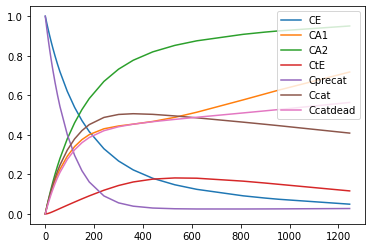

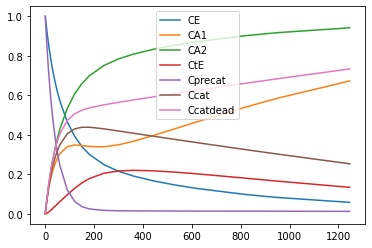

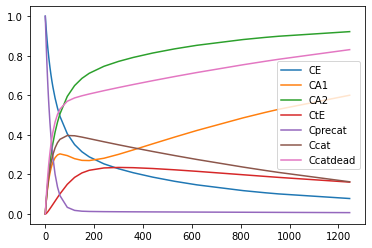

In [37]:
# check to see if the data got generated right before noise is added
plt.figure()
plt.plot(timespan,exp_1.true[0][0][0], label = 'CE')
plt.plot(timespan,exp_1.true[0][0][1], label = 'CA1')
plt.plot(timespan,exp_1.true[0][0][2], label = 'CA2')
plt.plot(timespan,exp_1.true[0][0][3], label = 'CtE')
plt.plot(timespan,exp_1.true[0][0][4], label = 'Cprecat')
plt.plot(timespan,exp_1.true[0][0][5], label = 'Ccat')
plt.plot(timespan,exp_1.true[0][0][6], label = 'Ccatdead')
plt.legend()
plt.figure()
plt.plot(timespan,exp_1.true[1][0][0], label = 'CE')
plt.plot(timespan,exp_1.true[1][0][1], label = 'CA1')
plt.plot(timespan,exp_1.true[1][0][2], label = 'CA2')
plt.plot(timespan,exp_1.true[1][0][3], label = 'CtE')
plt.plot(timespan,exp_1.true[1][0][4], label = 'Cprecat')
plt.plot(timespan,exp_1.true[1][0][5], label = 'Ccat')
plt.plot(timespan,exp_1.true[1][0][6], label = 'Ccatdead')
plt.legend()
plt.figure()
plt.plot(timespan,exp_1.true[2][0][0], label = 'CE')
plt.plot(timespan,exp_1.true[2][0][1], label = 'CA1')
plt.plot(timespan,exp_1.true[2][0][2], label = 'CA2')
plt.plot(timespan,exp_1.true[2][0][3], label = 'CtE')
plt.plot(timespan,exp_1.true[2][0][4], label = 'Cprecat')
plt.plot(timespan,exp_1.true[2][0][5], label = 'Ccat')
plt.plot(timespan,exp_1.true[2][0][6], label = 'Ccatdead')
plt.legend()

In [38]:
# Check the R-squareds for the true rate constants for each temperature so we can see how well our estimate are later on
exp_1.get_true_r2()

16.707867043019768
17.44994903322814
19.228393485763803


11.41461252445878
11.41461252445878
11.41461252445878
11.414611138723021
11.414612196870475
11.414612158051588
11.414612623573987
11.41461263016006
11.414612176254177
-28.008706360655232
11.67021907629909
11.670217360380208
11.670220648206179
11.670217489769003
11.670219032629063
11.670218367674082
11.670219598716432
12.854963881574756
12.854962581432256
12.854964888583016
12.854962677137932
12.85496389151003
12.854963480091392
12.854964016817105
14.116926974475822
14.116926345957278
14.11692731365126
14.11692629171567
14.116927040778819
14.116926893629433
14.116926682152199
15.087036178281094
15.087035341102595
15.087036908718225
15.087035253890258
15.087036164076286
15.087035889714521
15.08703632658397
15.567606133632355
15.567605980993427
15.567606193516374
15.56760583190059
15.567606194209567
15.567606227246877
15.567605674464913
15.624658648221564
15.624657833134952
15.624659159174275
15.624657898478372
15.624658598460716
15.62465829976794
15.624659265726848
16.22909161253349
16.2

16.716501328716102
16.71650133373435
16.71650130469386
16.716501302734798
16.716501328038778
16.716501331422062
16.716501327582403
16.71688724127062
16.71688724762867
16.71688721684068
16.716887216643048
16.716887240869173
16.71688724473498
16.716887237637856
16.71763437997975
16.71763438340323
16.717634357516857
16.717634354475894
16.7176343791282
16.717634381676827
16.717634381132566
16.718560548417244
16.718560567226977
16.718560519736332
16.718560534570734
16.71856055055747
16.71856055887678
16.718560522974432
16.71689140603487
16.719187268456388
16.71918727127128
16.719187247775338
16.71918724488591
16.719187267515252
16.719187269737603
16.719187270085573
16.719582682416817
16.719582691765403
16.719582658919
16.7195826634293
16.719582682827827
16.719582687406355
16.719582672848297
16.719574879569457
16.71987846919081
16.719878467653096
16.719878451455244
16.719878443917857
16.719878467519692
16.7198784678778
16.71987847813947
16.72014963822506
16.720149649752006
16.72014961429541


16.727606514720218
16.727606502036636
16.72760650545621
16.72760651104752
16.727606512702618
16.727606505420283
16.727631914259938
16.72763191299316
16.727631908844874
16.727631905710737
16.727631913487766
16.727631913261007
16.72763191841852
16.727661755700193
16.72766175962401
16.72766174750523
16.7276617506971
16.727661756111804
16.727661757702094
16.727661750799776
16.727685415305412
16.727685414174914
16.727685410090764
16.727685407115672
16.72768541458089
16.727685414403396
16.727685419196703
16.72770582771409
16.72770583210317
16.727705819622482
16.7277058231876
16.727705828294887
16.727705829957117
16.72770582211107
16.727738925491657
16.727738927211178
16.727738918995758
16.72773891928049
16.727738925469495
16.72773892620865
16.72773892456101
16.727760798892724
16.727760800012533
16.727760792922457
16.72776079245244
16.727760798728223
16.7277607992825
16.727760798996968
16.727800898454028
16.727800900831227
16.727800892089853
16.72780089318051
16.72780089856737
16.727800899608

17.44253023857185
17.442530226447463
17.442530238886
17.442530229699514
17.442530234423053
17.442530234694225
17.44321037834945
17.443210372942502
17.443210391307645
17.443210370268705
17.44321037726813
17.443210370082515
17.44321041774806
17.443895195896793
17.443895207434167
17.4438951958674
17.44389520820119
17.443895198994902
17.443895203811294
17.443895203366626
17.444531813680435
17.444531807678512
17.444531826422885
17.444531805758643
17.44453181247213
17.444531805441247
17.44453185217602
17.44512955708487
17.445129568314687
17.445129556974393
17.445129569329016
17.44512956018165
17.445129565128255
17.44512956338758
17.445734103349896
17.44573409711473
17.445734116005607
17.44573409522532
17.445734102301383
17.44573409506458
17.44573414107331
17.446359701934142
17.446359712186215
17.446359701964433
17.446359713794305
17.446359704832773
17.44635970953454
17.446359708749227
17.446960317771506
17.446960311571384
17.446960329850977
17.44696031038329
17.446960316775787
17.44696031001

17.46214198937423
17.462141989037644
17.46214199080778
17.46214198910823
17.462141989372768
17.46214198895364
17.46214199355312
17.462156496052884
17.462156496942242
17.46215649658927
17.462156497166134
17.462156496288447
17.462156496832655
17.4621564979249
17.462168878622528
17.462168877966686
17.46216888003307
17.46216887802715
17.462168878561663
17.462168877911466
17.462168882885372
17.46217923334549
17.462179234516597
17.462179233539523
17.46217923475731
17.462179233630295
17.462179234401738
17.46217923434934
17.462189637269127
17.462189636595024
17.462189638572976
17.46218963661634
17.4621896372027
17.462189636532173
17.462189641248735
17.462198185836762
17.462198186901354
17.46219818598484
17.4621981871204
17.462198186096508
17.462198186791387
17.462198186736956
17.462205776594978
17.462205775754335
17.46220577791105
17.462205775718942
17.46220577649594
17.46220577568554
17.462205780592093
17.46221251557656
17.462212516786625
17.462212515533516
17.462212517020532
17.4622125158595

19.230172443698876
19.23017242062216
19.23017241821128
19.230172414420657
19.230172431539128
19.243595619343928
19.2435955827229
19.24359563625616
19.24359563650168
19.243595624439923
19.243595629463826
19.243595610198778
19.094278828564875
19.24604126908463
19.246041214116893
19.246041294825112
19.246041269289805
19.246041269070368
19.246041262696092
19.246041291212606
19.24813926542452
19.24813922875063
19.248139283748404
19.248139277472603
19.2481392688902
19.248139271569837
19.248139263197242
19.250055457630612
19.25005540667065
19.250055482556924
19.250055455505763
19.250055457286415
19.250055449711965
19.250055481610268
19.251835556801883
19.2518355268736
19.251835573048858
19.251835569422468
19.251835560712088
19.251835564115456
19.251835551924717
19.25347447340107
19.253474425379537
19.253474497460193
19.253474469931664
19.253474472426348
19.253474464188134
19.25347449964907
19.254997157121895
19.254997131516447
19.254997172157267
19.254997169435757
19.254997160765335
19.254997

19.27990251692996
19.279902516825082
19.27990251728948
19.27990251593604
19.27990251712918
19.279902514343082
19.279939042717395
19.27993904232784
19.279939044748467
19.279939043408334
19.279939042967975
19.279939042825315
19.27993904466128
19.27996277697887
19.279962776343776
19.27996277905086
19.27996277741156
19.27996277718595
19.279962776814525
19.279962779319064
19.28001286337382
19.280012863347906
19.28001286515481
19.280012864146386
19.280012863672773
19.280012863678557
19.28001286481323
19.280063318690647
19.28006331544029
19.28006332119473
19.280063317225242
19.280063318401748
19.28006331612213
19.280063324955744
19.279974172629718
19.28011858731288
19.280118587336386
19.28011858888074
19.2801185879596
19.280118587589463
19.280118587551392
19.280118588731487
19.280147892379837
19.280147891302818
19.28014789419168
19.280147892314154
19.280147892443622
19.280147891669824
19.28014789540322
19.280134268105122
19.280167394648334
19.28016739547872
19.28016739587717
19.28016739580584

<Figure size 432x288 with 0 Axes>

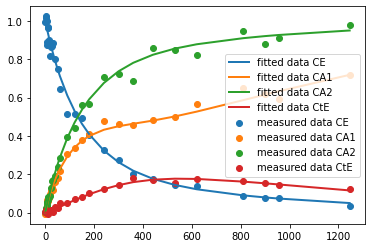

<Figure size 432x288 with 0 Axes>

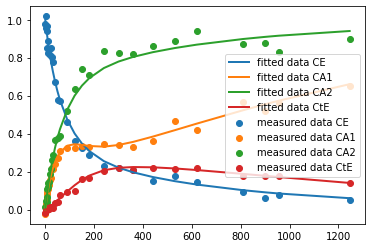

<Figure size 432x288 with 0 Axes>

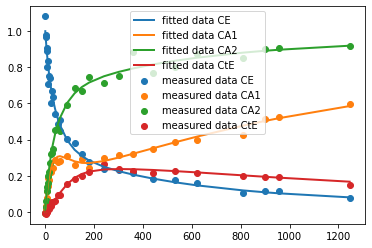

In [39]:
# and now we fit the data we generated and see, with the right differential if the program can find our constants for every temperature
exp_1.fit_sys_all(24) # if temperatures of initial conditions were changed, the max score to fill in here is amount of initial conditions*8

Good results, the r-squareds are close to optimal, and the constants are on average only a few percent points off.

In [42]:
#construct kinetic parameters form the results at individual temperatures
exp_1.kin_params_guesses()

In [43]:
# These are our guesses for the optimization across different temperatures
print(exp_1.Eact_list)
print(exp_1.A_list)

[-18211.15690968874, -14454.674822159392, -15825.67318735262, -15964.651637776691, -12419.89996374545, -26760.11702581118]
[5.260425234094435, 1.7869700303849272, 0.7777629870448576, 16.475488556276286, 2.0037887548489652, 89.83701426960472]


In [45]:
# These are the real values, you can see we're already close
print(exp_1.pre_constants)
print(exp_1.E_acts)

[ 4.   1.6  1.   5.   2.  40. ]
[-17507.67079081 -14058.09983295 -16473.03587668 -12132.82763899
 -12396.90042988 -24312.24532045]


53.42698826697402
53.42698826697402
53.42698826697402
53.42698845517975
53.42698798698113
53.426988143681726
53.42698830682278
53.42698824741549
53.426988232184925
53.4269882595745
53.42698827412895
53.4269882690869
53.42698826443214
53.426988267873206
53.42698827056944
37.1592376548473
52.76651400996948
53.419938276671175
53.42697882001968
53.42700324593594
53.42700345708832
53.427002931263885
53.42700319207105
53.42700329751058
53.42700338922184
53.427003199083856
53.42700323760761
53.42700325397668
53.42700324689587
53.42700324252492
53.42700324253516
53.42700325124378
53.42702735686282
53.4270275383974
53.42702705581175
53.42702728503364
53.42702739953084
53.42702744155582
53.42702731905092
53.427027349749686
53.427027364548834
53.42702735811933
53.42702735411937
53.42702735499914
53.42702736089538
53.42706295997798
53.42706309002971
53.42706267633697
53.427062870237386
53.42706298756895
53.42706295773741
53.427062937145806
53.427062954977664
53.42706296720517
53.427062961529856
53

53.42733606696751
53.42733608339191
53.427336031980566
53.427336082067896
53.42733606823098
53.42733609889908
53.42733605509696
53.42733606666208
53.427336067807744
53.42733606677635
53.427336067365744
53.427336066338455
53.42733606741912
53.42733733577542
53.42733733413009
53.427337325224606
53.42733731759855
53.42733733103037
53.42733731350951
53.427337330451024
53.42733733620934
53.427337335992604
53.42733733613285
53.427337336624326
53.427337336578795
53.42733733530223
53.42733854466773
53.427338561008085
53.42733851076344
53.42733856062373
53.42733854625905
53.42733857748256
53.4273385327677
53.427338544361774
53.427338545482066
53.427338544461556
53.42733854503934
53.42733854401184
53.427338545127455
53.42733903831362
53.42733903601783
53.427339029761
53.42733901955157
53.427339033780406
53.42733901483448
53.427339033226
53.42733903877062
53.42733903848172
53.427339038679676
53.42733903914538
53.42733903914579
53.42733903781098
53.42734083257747
53.427340839487705
53.427340811741

53.4273670646007
18.572632935399298


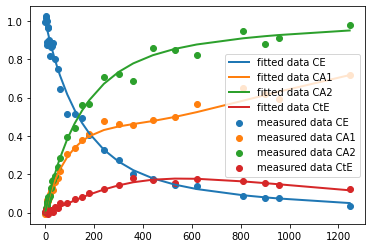

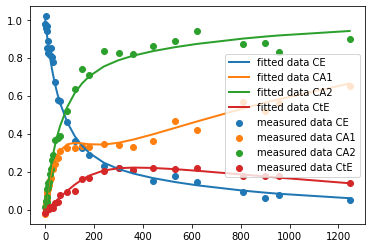

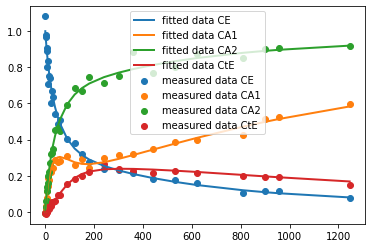

In [46]:
# Now let's fit all the data at once, regardless of temperature
exp_1.fit_sys_full(72) # The number to fill in here is number of temperatures*the number for the previous simulation

You will see this last part did very little for such accurate first guesses. In other documents we will see it's power better.